# Introduction
The goal of this notebook is to classify the chest X ray images of human lungs containing images with and without pneumonia. The dataset comes from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/kernels)

In [1]:
# Import libraries
from __future__ import print_function
import math
import PIL
import os
import keras   # Import keras framework with various functions, models and structures
import cv2

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt  # library for ploting math functions
import pandas as pd

from math import ceil
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from matplotlib import image
from skimage.color import rgb2gray
# Set parameters for plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

print ("TensorFlow version: " + tf.__version__)

dim=(128,128)

Using TensorFlow backend.


TensorFlow version: 2.1.0


In [2]:
def load_data(path):
    data = [image.imread(path + file) for file in os.listdir(path)]
    return data

def resize_data(data, dim):
    return [cv2.resize(rgb2gray(x), dim) for x in data]

def create_df(x0, x1):
    data = {'x': x0+x1, 'y': [0 for i in range(len(x0))]+ [1 for i in range(len(x1))]}
    df = pd.DataFrame(data=data)
    df = shuffle(df)
    return df.reset_index()

def load_and_preprocess_data(path, dim):
    return resize_data(load_data(path), dim)

def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    hm.invert_yaxis() # Invert the labels of the y-axis
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [3]:
# load and preprocess the Pneumonia data
path_to_images = '/Users/janek/Downloads/chest_xray/'
x_train_0 = load_and_preprocess_data(path_to_images + 'train/NORMAL/', dim)
x_train_1 = load_and_preprocess_data(path_to_images + 'train/PNEUMONIA/', dim)
x_test_0 = load_and_preprocess_data(path_to_images + 'test/NORMAL/', dim)
x_test_1 = load_and_preprocess_data(path_to_images + 'test/PNEUMONIA/', dim)
x_val_0 = load_and_preprocess_data(path_to_images + 'val/NORMAL/', dim)
x_val_1 = load_and_preprocess_data(path_to_images + 'val/PNEUMONIA/', dim)

In [4]:
LABELS= [1, 2]

In [5]:
# Define hyperparameters
batch_size = 512 # size of mini-baches
num_classes = 2 # number of classes of images
epochs = 1      # how many times all traing examples will be used to train the model

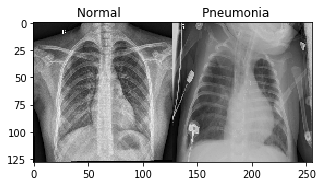

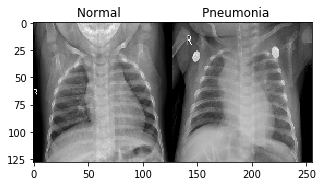

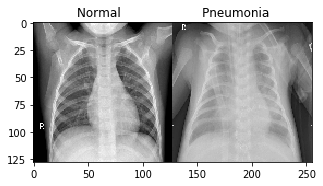

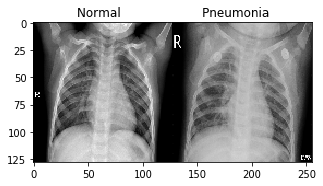

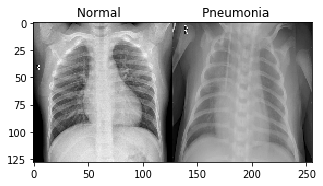

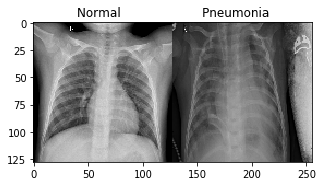

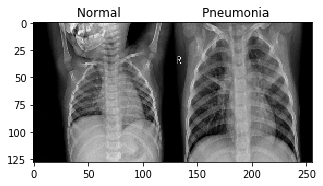

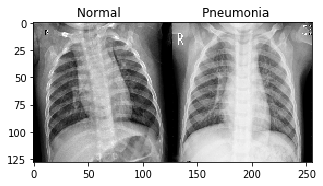

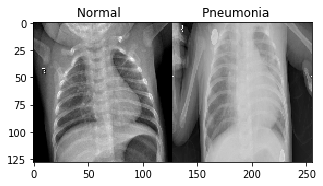

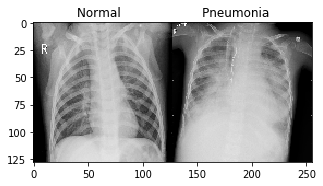

In [16]:
# Show a few sample images from the training set
# set default size of plots
for i in range(10):
    image = np.concatenate((x_train_0[i], x_train_1[i]), axis=1)
    plt.imshow(image, cmap='gray')
    plt.title("Normal                     Pneumonia")
    plt.show()

In [9]:
df_train = create_df(x_train_0, x_train_1)
df_test = create_df(x_test_0, x_test_1)
x_train = np.dstack(df_train.x.to_list()).reshape(len(df_train), dim[0], dim[1], 1)
y_train = keras.utils.to_categorical(df_train.y.to_list(), 2)
x_test = np.dstack(df_test.x.to_list()).reshape(len(df_test), dim[0], dim[1], 1)
y_test = keras.utils.to_categorical(df_test.y.to_list(), 2)

## Create the network structure

In [10]:
# Define the sequential Keras model composed of a few layers
model = Sequential()   # establishes the type of the network model
# Conv2D - creates a convolutional layer (https://keras.io/layers/convolutional/#conv2d) with 
# filters - specified number of convolutional filters
# kernel_size - defines the frame (sliding window) size where the convolutional filter is implemented
# activation - sets the activation function for this layers, here ReLU
# input_shape - defines the shape of the input matrix (vector), here input_shape = (dim[0], dim[1], 1)
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(dim[0], dim[1], 1)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling2D pools the max value from the frame (sliding window) of 2 x 2 size
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Implements the drop out with the probability of 0.25
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
#model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
# Finish the convolutional model and flatten the layer which does not affect the batch size.
model.add(Flatten())
# Use a dense layer (MLP) consisting of 256 neurons with relu activation functions
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(num_classes, activation='softmax'))

## Compile and train the network

In [11]:
# Compile the model using optimizer
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc']) # List of metrics to be evaluated by the model during training and testing: https://keras.io/models/model/#compile

# Learning rate reduction durint the training process: https://keras.io/callbacks/#reducelronplateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # quantity to be monitored (val_loss)
                                            factor=0.5, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            patience=5, # number of epochs that produced the monitored quantity with no improvement after which training will be stopped
                                            verbose=1,  # 0: quiet, 1: update messages.
                                            min_lr=0.001) # lower bound on the learning rate

# Augmentation of training data. It generates batches of tensor image data with real-time data augmentation. The data will be looped over in batches.
datagen = ImageDataGenerator(
        rotation_range=10,       # rotate images in degrees up to the given degrees
        width_shift_range=0.1,   # shift images horizontally
        height_shift_range=0.1,  # shift images vertically
        horizontal_flip=True)    # flip images (left<->right)
# Computes the internal data stats related to the data-dependent transformations, based on an array of samples x_train
datagen.fit(x_train)

# Train the model, validate, evaluate, and present scores
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            steps_per_epoch=x_train.shape[0]//batch_size,  # no of mini-batches 
                            validation_data=(x_test, y_test),
                            verbose=1,
                            callbacks=[learning_rate_reduction])

Epoch 1/20
10/10 [==============================] - 467s 47s/step - loss: 144.3523 - acc: 0.6505 - val_loss: 0.6825 - val_acc: 0.6250
Epoch 2/20
10/10 [==============================] - 446s 45s/step - loss: 0.6140 - acc: 0.7232 - val_loss: 0.6809 - val_acc: 0.6250
Epoch 3/20
10/10 [==============================] - 494s 49s/step - loss: 0.5909 - acc: 0.7395 - val_loss: 0.6737 - val_acc: 0.6250
Epoch 4/20
10/10 [==============================] - 395s 39s/step - loss: 0.5932 - acc: 0.7360 - val_loss: 0.6738 - val_acc: 0.6250
Epoch 5/20
10/10 [==============================] - 1741s 174s/step - loss: 0.5782 - acc: 0.7487 - val_loss: 0.6787 - val_acc: 0.6250
Epoch 6/20
10/10 [==============================] - 398s 40s/step - loss: 0.5808 - acc: 0.7439 - val_loss: 0.6751 - val_acc: 0.6250

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.5.
Epoch 7/20
10/10 [==============================] - 436s 44s/step - loss: 0.5873 - acc: 0.7375 - val_loss: 0.6739 - val_acc: 0.6250
Epoch 8/2

## Evaluate, score and plot the accuracy and the loss

Test loss: 0.6716048962030655
Test accuracy: 0.625


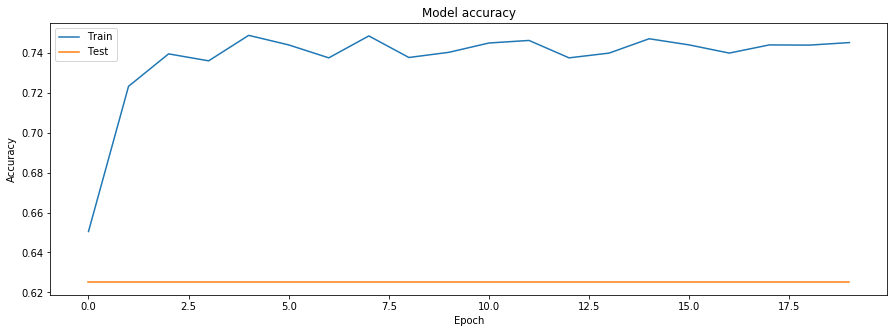

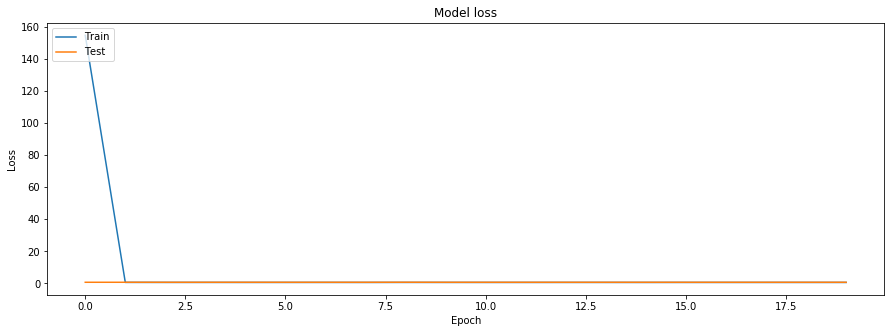

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values: https://keras.io/visualization/#training-history-visualizatio
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

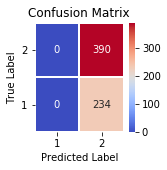

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
# Use the trained model for predictions of the test data
y_pred_test = model.predict(x_test)

# Take the class with the highest probability from the test predictions as a winning one
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

# Show the confution matrix of the collected results
show_confusion_matrix(max_y_test, max_y_pred_test, num_classes)

# Print classification report
print(classification_report(max_y_test, max_y_pred_test))

Number of misclassified examples:  234
Misclassified examples:
[  0   2   4   6   7   8   9  12  13  18  19  23  24  29  31  32  36  37
  42  44  47  56  58  59  60  66  67  69  71  73  75  79  80  84  90  91
  92  94  96  97 100 101 104 106 113 115 117 123 129 130 131 132 136 139
 141 142 143 145 151 154 155 156 157 158 159 160 162 166 171 172 173 174
 178 179 180 187 188 189 190 196 199 202 205 206 210 212 214 222 223 225
 226 229 230 231 232 235 236 238 240 241 243 244 245 246 248 249 250 252
 258 259 262 263 264 265 273 274 277 278 282 283 285 287 291 292 295 299
 301 302 303 304 307 308 309 310 314 315 317 318 319 326 327 336 337 342
 343 345 351 354 357 359 363 364 365 366 367 370 377 378 380 384 390 391
 392 393 404 413 414 417 423 428 431 435 436 440 441 442 443 445 447 451
 452 454 458 460 463 464 467 474 478 479 480 481 484 487 488 489 490 491
 498 501 516 522 525 528 531 535 536 537 538 541 542 547 549 554 555 556
 559 560 565 574 582 583 587 591 593 594 595 598 599 605 608 

TypeError: Invalid shape (128, 128, 1) for image data

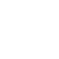

In [14]:
# Find out misclassified examples
classcheck = max_y_test - max_y_pred_test  # 0 - when the class is the same, 1 - otherwise
misclassified = np.where(classcheck != 0)[0]
num_misclassified = len(misclassified)

# Print misclassification report
print('Number of misclassified examples: ', str(num_misclassified))
print('Misclassified examples:')
print(misclassified)

# Conclusions
Trying different parameters did not increase the accuracy which means that the classic approach does not work with such complicated data. In order to increase the metrics, one should thouroughly preprocess the dataset before training the model (eg. segment the lungs from images). Furthermore one can think about using pretrained model as for example InceptionV3 and perform transfer learning. This tasks will be done in a project assignement. This notebook was just a warming up ;).   